微调

In [1]:
from matplotlib.lines import lineStyles
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import get_cosine_schedule_with_warmup
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm


In [2]:
tokenizer=AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token=tokenizer.eos_token

1.下载数据并解压缩

In [3]:
import requests
from pathlib import Path
import zipfile
zip_path=Path("sms_spam_collection.zip")
extracted_path=Path(".cache")/"sms_spam_collection"
data_file_path=extracted_path/"SMSSpamCollection.tsv"
url="https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"

def download(url,zip_path,extracted_path,data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists")
        return
    response=requests.get(url,stream=True,timeout=10)
    response.raise_for_status()
    #下载压缩包
    with zip_path.open("wb") as f:
        for chunk in response.iter_content(8192):
            if chunk:
                f.write(chunk)
    #解压文件
    with zipfile.ZipFile(zip_path,"r") as zf:
        zf.extractall(extracted_path)

    #文件重命名
    curr_file=extracted_path/data_file_path.stem
    curr_file.rename(data_file_path)
    print(f"{data_file_path} has been downloaded")
    zip_path.unlink()
    print(f"{zip_path} has been removed")

try:
    download(url,zip_path,extracted_path, data_file_path)
except requests.exceptions.RequestException as e:
    print(f"{e}")



.cache/sms_spam_collection/SMSSpamCollection.tsv already exists


2.数据预处理

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split



In [5]:
df=pd.read_csv(data_file_path,sep="\t",header=None,names=["Label","Text"])
df.head(5)

def create_balance_dataset(df):
    num_spam=(df["Label"]=="spam").sum()
    spam_set=df[df["Label"]=="spam"]
    ham_subset=df[df["Label"]=="ham"].sample(num_spam,random_state=123)
    return pd.concat([spam_set,ham_subset])

balance_df=create_balance_dataset(df)
print(balance_df["Label"].value_counts())

balance_df["Label"]=balance_df["Label"].map({"spam":1,"ham":0})

#拆分训练、验证、测试集
balance_df=balance_df.sample(frac=1,random_state=123).reset_index(drop=True)
train_df,temp_df=train_test_split(balance_df,test_size=0.3,random_state=123,stratify=balance_df["Label"])
val_df,test_df=train_test_split(temp_df,train_size=1.0/3,random_state=123,stratify=temp_df["Label"])
print(train_df["Label"].value_counts())

Label
spam    747
ham     747
Name: count, dtype: int64
Label
1    523
0    522
Name: count, dtype: int64


In [6]:
train_df.to_csv(".cache/train.csv",index=None)
val_df.to_csv(".cache/val.csv",index=None)
test_df.to_csv(".cache/test.csv",index=None)


创建 DataSet 和 DataLoader

In [7]:
#写法一：自定义 Dataset 类
class SimpleDataset(Dataset):
    def __init__(self,df,tokenizer,max_length=None):
        #max_length是用来填充
        self.data=df
        self.encoded_text=[tokenizer.encode(text) for text in df["Text"]]
        self.label=df["Label"]
        if max_length==None:
            max_length=max([len(t) for t in self.encoded_text])
        self.inputs=tokenizer(
            self.data["Text"].tolist(),
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True
        )

    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        item={"input_ids":self.inputs["input_ids"][index],
                "attention_mask":self.inputs["attention_mask"][index]}
        label=torch.tensor(self.label.iloc[index])
        return item,label
train_ds=SimpleDataset(train_df,tokenizer)
val_ds=SimpleDataset(val_df,tokenizer)
test_ds=SimpleDataset(test_df,tokenizer)
torch.manual_seed(123)
batch_size=8
train_loader=DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True,drop_last=True)
val_loader=DataLoader(dataset=val_ds,batch_size=batch_size,drop_last=True)
test_loader=DataLoader(dataset=test_ds,batch_size=batch_size,drop_last=True)







In [8]:
# #写法二：用 huggingface 的 datasets 类
# from datasets import Dataset,DatasetDict
# train_ds=Dataset.from_pandas(train_df)
# val_ds=Dataset.from_pandas(val_df)
# test_ds=Dataset.from_pandas(test_df)
#
# ds=DatasetDict(
#     {
#         "train":train_ds,
#         "val":val_ds,
#         "test":test_ds
#     }
# )
#
# encoded_ds=ds.map(
#     lambda x:tokenizer(x["Text"],truncation=True,padding="max_length",max_length=128),batched=True
# )
# encoded_ds.rename_column("Label","labels")
# encoded_ds.set_format(
#     type="torch",
#     columns=["input_ids", "attention_mask", "labels"]
# )
#
# train_loader = DataLoader(encoded_ds["train"], batch_size=8, shuffle=True,drop_last=True)
# val_loader   = DataLoader(encoded_ds["val"], batch_size=8,drop_last=True)
# test_loader  = DataLoader(encoded_ds["test"], batch_size=8,drop_last=True)


In [9]:
for x,y in train_loader:
    pass
print(x)
print(y.shape)
print(f"Batches of train_loader:{len(train_loader)}")
print(f"Batches of val_loader:{len(val_loader)}")
print(f"Batches of test_loader:{len(test_loader)}")

{'input_ids': tensor([[36705,   326,   334,   460,  2652,   319,   277,    65,  8537,   351,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [ 5840,   319,   257,  4512, 

训练模型

In [10]:
from transformers import AutoModel, AutoTokenizer
from transformers import AutoConfig
class GPTModelForClassfication(nn.Module):
    def __init__(self,model_name):
        super().__init__()
        self.gpt=AutoModel.from_pretrained(model_name)
        emb_dim=self.gpt.wte.embedding_dim
        self.classifier=nn.Linear(emb_dim,2,bias=False)
        #冻结gpt所有参数
        for p in self.gpt.parameters():
            p.requires_grad=False
        #解冻Norm 层和最后一个Transformer 层
        for p in self.gpt.ln_f.parameters():
            p.requires_grad=True
        for p in self.gpt.h[-1].parameters():
            p.requires_grad=True

    def forward(self,input_ids):
        outputs=self.gpt(**input_ids)
        cls_rep=outputs.last_hidden_state[:,-1,:]
        logits=self.classifier(cls_rep)
        return logits






In [27]:
model=GPTModelForClassfication("gpt2")

In [12]:
print(model)

GPTModelForClassfication(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (classifier): Linear(in_features=768, out_features=2, bias=False)
)


In [13]:
trainable=sum([p.numel() for p in model.parameters() if p.requires_grad==True])
All=sum([p.numel() for p in model.parameters()])
print(trainable/All)


0.05698221967130152


计算准确率

In [14]:
def calc_accracy_loader(data_loader,model,device,num_batches=None):
    model.eval()
    corrected_predictions,all_predictions=0,0
    if num_batches is None:
        num_batches=len(data_loader)
    else:
        num_batches=min(len(data_loader),num_batches)
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(data_loader):
            #input_ids是字典,batch_size*seq_len*emb_dim,labels是 batch_size*2
            if i<num_batches:
                inputs={k:v.to(device) for k,v in inputs.items()}
                labels=labels.to(device)
                logits=model(inputs)
                predicted_label=torch.argmax(logits,dim=-1)
                all_predictions+=predicted_label.shape[0]
                corrected_predictions+=(predicted_label==labels).sum().item()
            else:
                break
        accuracy=corrected_predictions/all_predictions
    model.train()
    return accuracy


看看初始的准确率

In [28]:
device="mps"
model.to(device)
torch.manual_seed(123)
train_accuracy=calc_accracy_loader(train_loader,model,device,num_batches=5)
train_accuracy

0.4

求 batch 和 loader 的损失函数以及抽样 evaluate 损失

In [16]:
def calc_loss_batch(inputs,labels,model,device,criterion):
    inputs={k:v.to(device) for k,v in inputs.items()}
    labels=labels.to(device)
    logits=model(inputs)
    loss=criterion(logits,labels)
    return loss

def calc_loss_loader(data_loader,model,device,criterion,num_batches=None):
    num_batches=len(data_loader) if num_batches is None else min(len(data_loader),num_batches)
    loss=0
    for i,(inputs,labels) in enumerate(data_loader):
        if i<num_batches:
            loss+=calc_loss_batch(inputs,labels,model,device,criterion).item()
        else:
            break
    return loss/num_batches if num_batches!=0 else float("nan")

def evaluate_model(model,train_loader,val_loader,device,criterion,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss=calc_loss_loader(train_loader,model,device,criterion,eval_iter)
        val_loss=calc_loss_loader(val_loader,model,device,criterion,eval_iter)
    model.train()
    return train_loss,val_loss



定义模型训练（微调）函数

In [30]:
def train_finetune_model(model,train_loader,val_loader,optimizer,criterion,device,num_epochs,eval_freq,eval_iter,schduler=None):
    train_losses,val_losses,train_acc,val_acc=[],[],[],[]
    samples_seen,global_step=0,0

    for epoch in range(num_epochs):
        model.train()
        for inputs,labels in tqdm(train_loader):
            optimizer.zero_grad()
            loss=calc_loss_batch(inputs,labels,model,device,criterion)
            loss.backward()
            optimizer.step()
            scheduler.step()
            samples_seen+=labels.shape[0]
            global_step+=1

            if global_step%eval_freq==0:
                train_loss,val_loss=evaluate_model(model,train_loader,val_loader, device, criterion, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1},Step{global_step},train_loss:{train_loss:.3f},val_loss:{val_loss:.3f}")

        #每轮 epoch过后监测一次 accuracy
        train_accuracy=calc_accracy_loader(train_loader,model,device,eval_iter)
        val_accuracy=calc_accracy_loader(val_loader,model,device,eval_iter)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        print(f"Epoch {epoch+1}:Train Accuracy {train_accuracy:.3f}")
        print(f"Epoch {epoch+1}:Val Accuracy {val_accuracy:.3f}")
    return train_losses,val_losses,train_acc,val_acc,samples_seen






In [31]:
#优化器、损失函数、调度器（可选）
optimizer = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad==True), lr=5e-5, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()
num_training_steps=5*len(train_loader)
scheduler=get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_training_steps//10,
    num_training_steps=num_training_steps
)

device='mps'
train_losses, val_losses, train_acc, val_acc, samples_seen=train_finetune_model(model,train_loader,val_loader,optimizer,criterion,device,num_epochs=5,eval_freq=50,eval_iter=5,schduler=scheduler)

 40%|████      | 52/130 [00:08<00:23,  3.30it/s]

Epoch 1,Step50,train_loss:0.740,val_loss:0.782


 78%|███████▊  | 102/130 [00:16<00:08,  3.28it/s]

Epoch 1,Step100,train_loss:0.559,val_loss:0.596


100%|██████████| 130/130 [00:20<00:00,  6.33it/s]


Epoch 1:Train Accuracy 0.925
Epoch 1:Val Accuracy 0.925


 17%|█▋        | 22/130 [00:04<00:32,  3.36it/s]

Epoch 2,Step150,train_loss:0.317,val_loss:0.366


 55%|█████▌    | 72/130 [00:12<00:17,  3.38it/s]

Epoch 2,Step200,train_loss:0.132,val_loss:0.293


 92%|█████████▏| 120/130 [00:20<00:04,  2.09it/s]

Epoch 2,Step250,train_loss:0.121,val_loss:0.272


100%|██████████| 130/130 [00:21<00:00,  5.99it/s]


Epoch 2:Train Accuracy 1.000
Epoch 2:Val Accuracy 0.900


 32%|███▏      | 42/130 [00:07<00:27,  3.16it/s]

Epoch 3,Step300,train_loss:0.065,val_loss:0.266


 71%|███████   | 92/130 [00:15<00:11,  3.36it/s]

Epoch 3,Step350,train_loss:0.050,val_loss:0.264


100%|██████████| 130/130 [00:20<00:00,  6.27it/s]


Epoch 3:Train Accuracy 1.000
Epoch 3:Val Accuracy 0.925


  8%|▊         | 10/130 [00:02<00:54,  2.18it/s]

Epoch 4,Step400,train_loss:0.039,val_loss:0.264


 46%|████▌     | 60/130 [00:11<00:36,  1.91it/s]

Epoch 4,Step450,train_loss:0.103,val_loss:0.268


 85%|████████▍ | 110/130 [00:19<00:09,  2.09it/s]

Epoch 4,Step500,train_loss:0.068,val_loss:0.267


100%|██████████| 130/130 [00:22<00:00,  5.80it/s]


Epoch 4:Train Accuracy 1.000
Epoch 4:Val Accuracy 0.925


 23%|██▎       | 30/130 [00:05<00:57,  1.74it/s]

Epoch 5,Step550,train_loss:0.067,val_loss:0.268


 62%|██████▏   | 80/130 [00:14<00:25,  2.00it/s]

Epoch 5,Step600,train_loss:0.091,val_loss:0.269


100%|██████████| 130/130 [00:23<00:00,  5.54it/s]

Epoch 5,Step650,train_loss:0.096,val_loss:0.269


Epoch 5:Train Accuracy 1.000
Epoch 5:Val Accuracy 0.925


最终效果：展示 accuracy和可视化

In [32]:
train_accuracy=calc_accracy_loader(train_loader,model,device)
val_accuracy=calc_accracy_loader(val_loader,model,device)
test_accuracy=calc_accracy_loader(test_loader,model,device)
print(f"Train Accuracy On Train Dataset: {train_accuracy:.3f}")
print(f"Val Accuracy On Val Dataset: {val_accuracy:.3f}")
print(f"Test Accuracy On Test Dataset: {test_accuracy:.3f}")

Train Accuracy On Train Dataset: 0.979
Val Accuracy On Val Dataset: 0.951
Test Accuracy On Test Dataset: 0.973


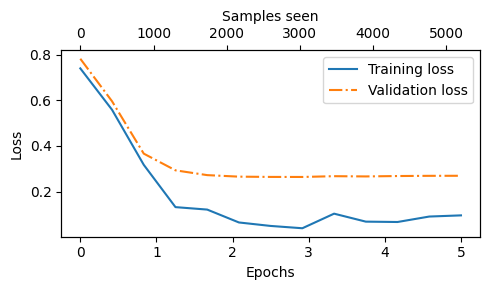

In [33]:
import matplotlib.pyplot as plt
def plot_loss(epochs,samples_seen,train_losses,val_losses,label="loss"):
    fig,ax1=plt.subplots(figsize=(5,3))
    ax1.plot(epochs,train_losses,label=f"Training {label}")
    ax1.plot(epochs,val_losses,linestyle='-.',label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2=ax1.twiny()
    ax2.plot(samples_seen,train_losses,alpha=0)
    ax2.set_xlabel("Samples seen")

    fig.tight_layout()
    plt.savefig("Loss.png")
    plt.show()
epochs=torch.linspace(0,5,len(train_losses))
samples_seen=torch.linspace(0,samples_seen,len(train_losses))
plot_loss(epochs,samples_seen,train_losses,val_losses)


使用分类器

In [39]:
def classify(model,text,tokenizer,device):
    inputs=tokenizer([text],max_length=120,padding="max_length",truncation=True,return_tensors='pt')
    inputs={k:v.to(device) for k,v in inputs.items()}
    logits=model(inputs)
    predicted=torch.argmax(logits,dim=-1).item()
    return "spam" if predicted else "not spam"

In [42]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify(
     model,text_1, tokenizer, device
))

spam


In [40]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
classify(model,text_2,tokenizer, device)

'not spam'

保存模型

In [43]:
torch.save(model.state_dict(), "gpt2_classifier.pt")